### plot_time_course

In [20]:
#!/usr/bin/env python3
# coding: utf-8

# import os, re, sys
# import glob, json
# import argparse

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns

from pctk import multicellds 

sns.set(style="ticks", palette="Paired")
sns.set_context('paper')

# def create_parser():
#     parser = argparse.ArgumentParser(description="Plot total cell grouped as Alive/Necrotic/Apoptotic vs Time")
    
#     parser.add_argument("data_folder", action="store", help="folder were the data is stored")
    
#     parser.add_argument("--format", action="store", dest="format", choices=("physicell", "physiboss"),
#                         help="Format of the input data", default="physicell")

#     parser.add_argument("--figout", action="store", dest="fig_fname", default="./cell_vs_time.png",
#                         help="File name to save the plot")
                        
#     parser.add_argument("--csvout", action="store", dest="csv_fname", default=None,
#                         help="File name to store the summary table used for the plot")

#     return parser
    
# def pb_output_iterator(data_folder, sep=";"):
#     globing = os.path.join(data_folder, "cells_[0-9]*.txt")
#     for fname in sorted(glob.glob(globing)):
#         df = pd.read_csv(fname, sep=sep)
#         t = df.Time[0]
#         yield (t, df)

# def count_pb_files(data_folder):
#     globing = os.path.join(data_folder, "cells_[0-9]*.txt")
#     return len(glob.glob(globing))

In [21]:
covid_type_dict = {
    0: "default",
    1: "Epithelial",
    2: "immune",
    3: "CD8 Tcell",
    4: "macrophage",
    5: "neutrophil",
    6: "DC",
    7: "CD4 Tcell",
    8: "fibroblast"    
    }

covid_type_grouping = {
    "default": "default",
    "Epithelial": "Epithelial",
    "immune": "immune",
    "CD8 Tcell": "CD8 Tcell",
    "macrophage": "macrophage",
    "neutrophil": "neutrophil",
    "DC": "DC",
    "CD4 Tcell": "CD4 Tcell",
    "fibroblast": "fibroblast"
    }

{0: 'default', 1: 'Epithelial', 2: 'immune', 3: 'CD8 Tcell', 4: 'macrophage', 5: 'neutrophil', 6: 'DC', 7: 'CD4 Tcell', 8: 'fibroblast'}
{'default': 'default', 'Epithelial': 'Epithelial', 'immune': 'immune', 'CD8 Tcell': 'CD8 Tcell', 'macrophage': 'macrophage', 'neutrophil': 'neutrophil', 'DC': 'DC', 'CD4 Tcell': 'CD4 Tcell', 'fibroblast': 'fibroblast'}
	Processing time step: 0
	Processing time step: 20
	Processing time step: 40
	Processing time step: 60
	Processing time step: 80
	Processing time step: 100
	Processing time step: 120
	Processing time step: 140
	Processing time step: 160
	Processing time step: 180
	Processing time step: 200
	Processing time step: 220
	Processing time step: 240
	Processing time step: 260
	Processing time step: 280
	Processing time step: 300
	Processing time step: 320
	Processing time step: 340
	Processing time step: 360
	Processing time step: 380
	Processing time step: 400
	Processing time step: 420
	Processing time step: 440
	Processing time step: 460
	P

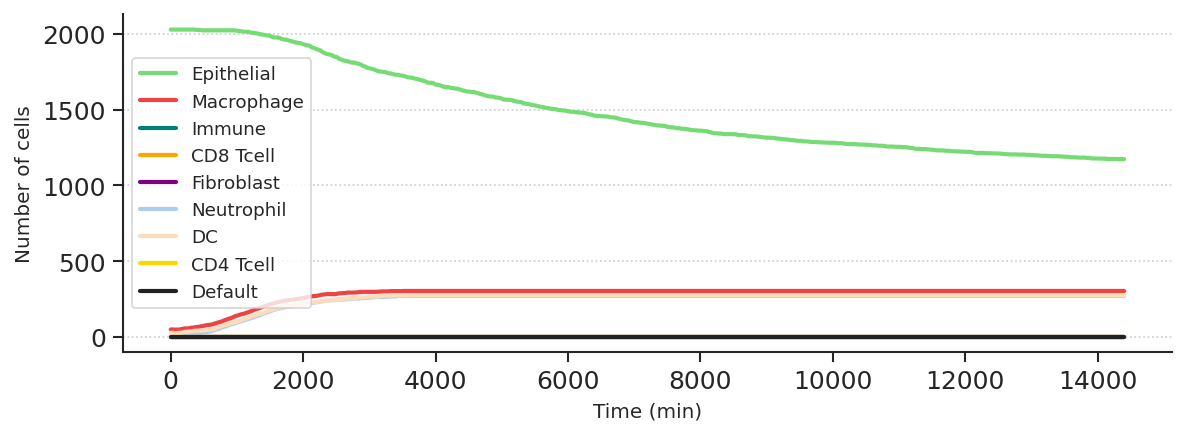

In [29]:
# parser = create_parser()
# args = parser.parse_args()
name = "PhysiCell/output_APN"
data_folder = f"../../{name}"
# print (data_folder)
fig_fname  = name
csv_fname = name

phases_dict = covid_type_dict
phase_grouping = covid_type_grouping
print(phases_dict)
print(phase_grouping)

# Globing output files according to the output format specified
# if args.format == 'physicell':
phase_col = "cell_type"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()

columns = ["Epithelial", "immune", "CD8 Tcell", "macrophage", "neutrophil", "DC", "CD4 Tcell", "fibroblast","default"]
data = np.zeros((num_of_files, 9), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    # Alive, Apoptotic, Necrotic
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v
        
bottom_line_3D = df_time_course.iloc[-1:]

# Plot the total number of cells of each type vs time
sns.set_context('paper')
patch_color = "lightgrey"

fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

# plot Alive vs Time
curve_params = {}
curve_params['Epithelial'] = {'color': '#75db75', 'label': 'Epithelial'}
curve_params['macrophage'] = {'color': '#ef4242', 'label': 'Macrophage'}
curve_params['immune'] = {'color':'#008080', 'label': 'Immune'}
curve_params['CD8 Tcell'] = {'color':'#FFA500', 'label': 'CD8 Tcell'}
curve_params['fibroblast'] = {'color':'#800080', 'label': 'Fibroblast'}
curve_params['neutrophil'] = {'color':'#abcdef', 'label': 'Neutrophil'}
curve_params['DC'] = {'color':'#fedcba', 'label': 'DC'}
curve_params['CD4 Tcell'] = {'color':'#FFD700', 'label': 'CD4 Tcell'}
curve_params['default'] = {'color':'#222222', 'label': 'Default'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# setting axes labels
axes.set_xlabel("Time (min)")
axes.set_ylabel("Number of cells")

axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)

# Showing legend
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.grid(linestyle='dotted')
axes.legend()
fig.tight_layout()

{0: 'default', 1: 'Epithelial', 2: 'immune', 3: 'CD8 Tcell', 4: 'macrophage', 5: 'neutrophil', 6: 'DC', 7: 'CD4 Tcell', 8: 'fibroblast'}
{'default': 'default', 'Epithelial': 'Epithelial', 'immune': 'immune', 'CD8 Tcell': 'CD8 Tcell', 'macrophage': 'macrophage', 'neutrophil': 'neutrophil', 'DC': 'DC', 'CD4 Tcell': 'CD4 Tcell', 'fibroblast': 'fibroblast'}
	Processing time step: 0
	Processing time step: 60
	Processing time step: 120
	Processing time step: 180
	Processing time step: 240
	Processing time step: 300
	Processing time step: 360
	Processing time step: 420
	Processing time step: 480
	Processing time step: 540
	Processing time step: 600
	Processing time step: 660
	Processing time step: 720
	Processing time step: 780
	Processing time step: 840
	Processing time step: 900
	Processing time step: 960
	Processing time step: 1020
	Processing time step: 1080
	Processing time step: 1140
	Processing time step: 1200
	Processing time step: 1260
	Processing time step: 1320
	Processing time ste

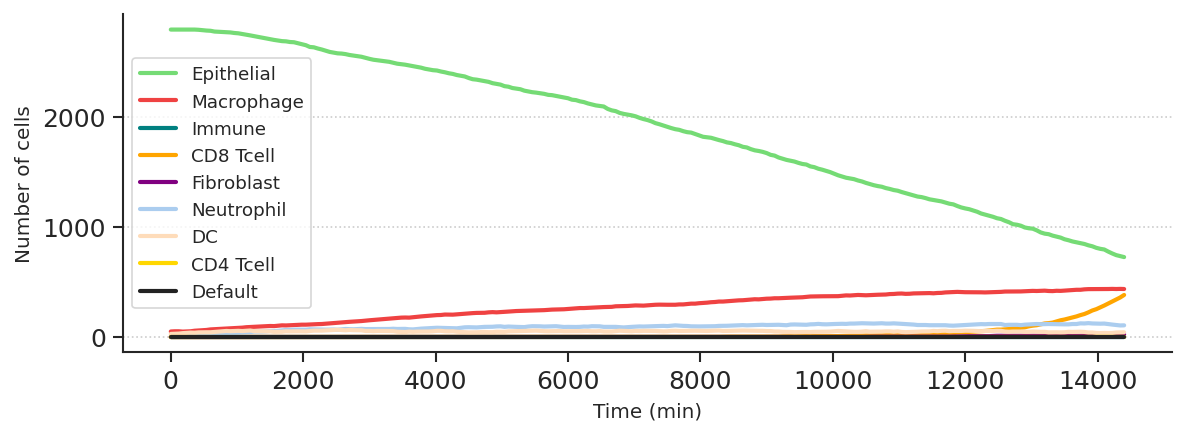

In [ ]:
name = "PhysiCell_ori/output_C141"
data_folder = f"../../{name}"
# print (data_folder)
fig_fname  = name
csv_fname = name

phases_dict = covid_type_dict
phase_grouping = covid_type_grouping
print(phases_dict)
print(phase_grouping)

phase_col = "cell_type"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()

columns = ["Epithelial", "immune", "CD8 Tcell", "macrophage", "neutrophil", "DC", "CD4 Tcell", "fibroblast","default"]
data = np.zeros((num_of_files, 9), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v
        
bottom_line_2D = df_time_course.iloc[-1:]

# Plot the total number of cells of each type vs time
sns.set_context('paper')
patch_color = "lightgrey"

fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

curve_params = {}
curve_params['Epithelial'] = {'color': '#75db75', 'label': 'Epithelial'}
curve_params['macrophage'] = {'color': '#ef4242', 'label': 'Macrophage'}
curve_params['immune'] = {'color':'#008080', 'label': 'Immune'}
curve_params['CD8 Tcell'] = {'color':'#FFA500', 'label': 'CD8 Tcell'}
curve_params['fibroblast'] = {'color':'#800080', 'label': 'Fibroblast'}
curve_params['neutrophil'] = {'color':'#abcdef', 'label': 'Neutrophil'}
curve_params['DC'] = {'color':'#fedcba', 'label': 'DC'}
curve_params['CD4 Tcell'] = {'color':'#FFD700', 'label': 'CD4 Tcell'}
curve_params['default'] = {'color':'#222222', 'label': 'Default'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

axes.set_xlabel("Time (min)")
axes.set_ylabel("Number of cells")

axes.tick_params(axis='x', labelsize=12)
axes.tick_params(axis='y', labelsize=12)

# Showing legend
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.grid(linestyle='dotted')
axes.legend()
fig.tight_layout()

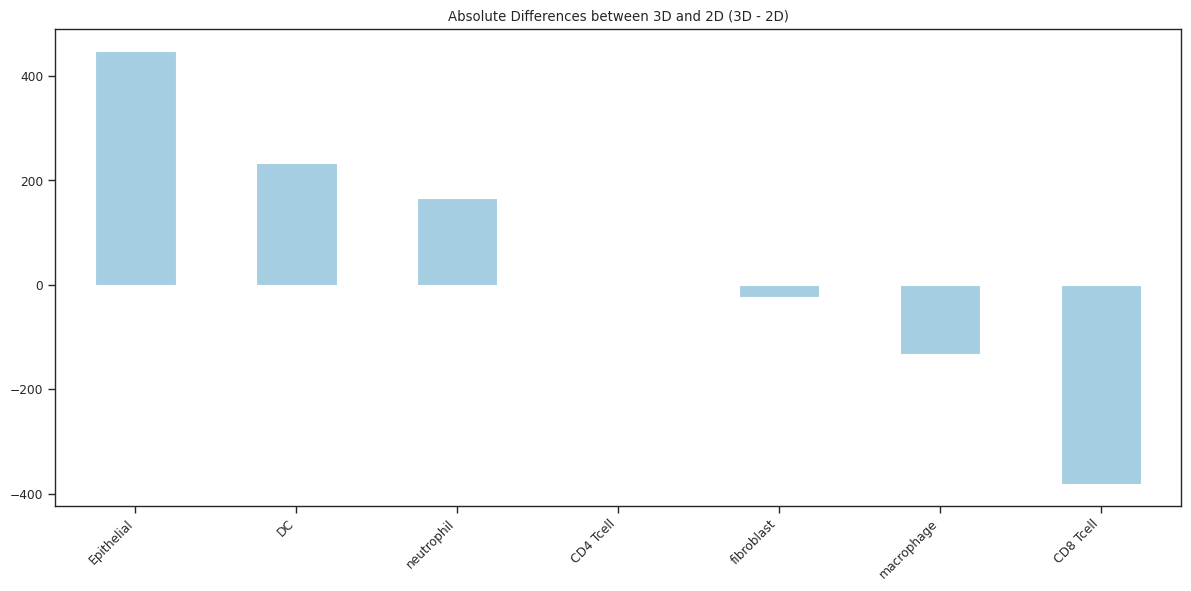

In [36]:
# Get columns to exclude
exclude_columns = ['immune', 'default', 'time']

# Filter the columns from both dataframes
bottom_line_2D_filtered = bottom_line_2D.drop(columns=exclude_columns, errors='ignore')
bottom_line_3D_filtered = bottom_line_3D.drop(columns=exclude_columns, errors='ignore')

# Compare the two bottom lines
differences = bottom_line_3D_filtered.values.flatten() - bottom_line_2D_filtered.values.flatten()

# Get filtered column names for the index
columns = bottom_line_2D_filtered.columns

# Display absolute differences and percentage differences
comparison_df = pd.DataFrame({
    '2D': bottom_line_2D_filtered.values.flatten(),
    '3D': bottom_line_3D_filtered.values.flatten(),
    'Absolute Diff': differences,
    'Percentage Diff': (differences / bottom_line_2D_filtered.values.flatten() * 100).round(2)
}, index=columns)

# Sort by absolute difference to see biggest changes
comparison_df = comparison_df.sort_values(by='Absolute Diff', ascending=False)

# print("Comparison between 2D and 3D bottom lines (filtered):")
# print(comparison_df)

# Visualization
# import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
comparison_df['Absolute Diff'].plot(kind='bar')
plt.title('Absolute Differences between 3D and 2D (3D - 2D)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# # parser = create_parser()
# # args = parser.parse_args()
# name = "PhysiCell/output_APN"
# data_folder = f"../../{name}"
# # print (data_folder)
# fig_fname  = name
# csv_fname = name

# phases_dict = multicellds.default_phases_dict
# phase_grouping = multicellds.default_phase_grouping
# print(phases_dict)
# print(phase_grouping)

# # Globing output files according to the output format specified
# # if args.format == 'physicell':
# phase_col = "current_phase"
# mcds = multicellds.MultiCellDS(output_folder=data_folder)
# df_iterator = mcds.cells_as_frames_iterator()
# num_of_files = mcds.cells_file_count()
# # elif args.format == 'physiboss':
# #     phase_col = "phase"
# #     df_iterator = pb_output_iterator(args.data_folder)
# #     num_of_files = count_pb_files(args.data_folder)

# # Initializing a Pandas Databrafe to store the data
# columns = ["time", "alive", "apoptotic", "necrotic"]
# data = np.zeros((num_of_files, 4), dtype=int)
# df_time_course = pd.DataFrame(columns=columns, data=data)

# # print("Reading cell_output files from %i input files from %s" % (num_of_files, data_folder))
# # Iterating over all cell_output files
# for i, (t, df) in enumerate(df_iterator):
#     print("\tProcessing time step: %.0f" % t)

#     # Rename the phases integer codes using the phases_dict as the mapping
#     s = df[phase_col]
#     s.replace(to_replace=phases_dict, inplace=True)
    
#     # Count the number of cells in each phase
#     counts = s.value_counts()

#     df_time_course.loc[i, 'time'] = t
#     # group the previous phases count into the three general classes:
#     # Alive, Apoptotic, Necrotic
#     for k, v in counts.to_dict().items():
#         if k not in phase_grouping:
#             continue
#         df_time_course.loc[i, phase_grouping[k]] += v
        
#         # print("Finish processing files")    
# # Set time column as the dataframe index
# sns.set_context('paper')
# patch_color = "lightgrey"

# # print("Creating figure")
# # Create a figure
# # fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)
# fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

# # plot Alive vs Time
# curve_params = {}
# curve_params['alive'] = {'color': '#75db75', 'label': 'Alive'}
# curve_params['apoptotic'] = {'color': '#ef4242', 'label': 'Apoptotic'}
# curve_params['necrotic'] = {'color':'#97723d', 'label': 'Necrotic'}
# line_width = 2.
# for k,pdict in curve_params.items():
#     c = pdict['color']
#     l = pdict['label']
#     axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# # setting axes labels
# axes.set_xlabel("Time (min)")
# axes.set_ylabel("Number of cells")

# axes.tick_params(axis='x', labelsize=12)
# axes.tick_params(axis='y', labelsize=12)

# # Showing legend
# axes.spines['right'].set_visible(False)
# axes.spines['top'].set_visible(False)
# axes.yaxis.grid(linestyle='dotted')
# axes.legend()
# # color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}
# fig.tight_layout()

In [25]:
# name = "PhysiCell_ori/output_C141"
# data_folder = f"../../{name}"
# # print (data_folder)
# fig_fname  = name
# csv_fname = name

# phases_dict = multicellds.default_phases_dict
# phase_grouping = multicellds.default_phase_grouping
# print(phases_dict)
# print(phase_grouping)

# phase_col = "current_phase"
# mcds = multicellds.MultiCellDS(output_folder=data_folder)
# df_iterator = mcds.cells_as_frames_iterator()
# num_of_files = mcds.cells_file_count()

# columns = ["time", "alive", "apoptotic", "necrotic"]
# data = np.zeros((num_of_files, 4), dtype=int)
# df_time_course = pd.DataFrame(columns=columns, data=data)

# for i, (t, df) in enumerate(df_iterator):
#     print("\tProcessing time step: %.0f" % t)

#     # Rename the phases integer codes using the phases_dict as the mapping
#     s = df[phase_col]
#     s.replace(to_replace=phases_dict, inplace=True)
    
#     # Count the number of cells in each phase
#     counts = s.value_counts()

#     df_time_course.loc[i, 'time'] = t
#     # group the previous phases count into the three general classes:
#     # Alive, Apoptotic, Necrotic
#     for k, v in counts.to_dict().items():
#         if k not in phase_grouping:
#             continue
#         df_time_course.loc[i, phase_grouping[k]] += v

#        # print("Finish processing files")

# sns.set_context('paper')
# patch_color = "lightgrey"

# # print("Creating figure")
# # Create a figure
# # fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=300)
# fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=150, sharex=True)

# # plot Alive vs Time
# curve_params = {}
# curve_params['alive'] = {'color': '#75db75', 'label': 'Alive'}
# curve_params['apoptotic'] = {'color': '#ef4242', 'label': 'Apoptotic'}
# curve_params['necrotic'] = {'color':'#97723d', 'label': 'Necrotic'}
# line_width = 2.
# for k,pdict in curve_params.items():
#     c = pdict['color']
#     l = pdict['label']
#     axes.plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# # setting axes labels
# axes.set_xlabel("Time (min)")
# axes.set_ylabel("Number of cells")

# axes.tick_params(axis='x', labelsize=12)
# axes.tick_params(axis='y', labelsize=12)

# # Showing legend
# axes.spines['right'].set_visible(False)
# axes.spines['top'].set_visible(False)
# axes.yaxis.grid(linestyle='dotted')
# axes.legend()
# # color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}
# fig.tight_layout()